<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/11_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb  
https://www.learnpytorch.io/09_pytorch_model_deployment/

In [71]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121


In [72]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [74]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [75]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [76]:
from torchvision.models import EfficientNet_B2_Weights, efficientnet_b2

effnetB2weights = EfficientNet_B2_Weights.DEFAULT
effnetB2transforms = effnetB2weights.transforms()
effnetB2 = efficientnet_b2(weights=effnetB2weights).to(device)

In [77]:
for param in effnetB2.features.parameters():
    param.requires_grad = False

In [78]:
from torchinfo import summary

summary(effnetB2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 1000]       --              Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              False
│    │    └─MBConv (0)                                   

In [79]:
set_seeds(42)

effnetB2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
).to(device)

In [80]:
from torchinfo import summary

summary(effnetB2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 3]     --         Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --         False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --         False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)      False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)       False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --         --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --         False
│    │    └─MBConv (0)                                       [1, 32, 112, 112] [1, 16, 112, 112] (1,448)    F

In [81]:
def create_effnetb2_model(num_classes:int=3):
    effnetB2weights = EfficientNet_B2_Weights.DEFAULT
    effnetB2transforms = effnetB2weights.transforms()
    effnetB2 = efficientnet_b2(weights=effnetB2weights)
    for param in effnetB2.features.parameters():
        param.requires_grad = False
    effnetB2.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )
    return effnetB2, effnetB2transforms

In [82]:
effnetB2, effnetB2_transforms = create_effnetb2_model(num_classes=3)

In [83]:
effnetB2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [84]:
from torchinfo import summary

summary(effnetB2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 3]          --              Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              False
│    │    └─MBConv (0)                                   

In [85]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetB2_transforms,
    batch_size=32
)

In [86]:
len(train_dataloader), len(test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [87]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetB2.parameters(), lr=0.001)

set_seeds(42)
effnetB2_results = engine.train(model=effnetB2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9583 | train_acc: 0.6042 | test_loss: 0.7250 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.6802 | train_acc: 0.8583 | test_loss: 0.5771 | test_acc: 0.9131
Epoch: 3 | train_loss: 0.5668 | train_acc: 0.8833 | test_loss: 0.4837 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4334 | train_acc: 0.9000 | test_loss: 0.4250 | test_acc: 0.9381
Epoch: 5 | train_loss: 0.4077 | train_acc: 0.9104 | test_loss: 0.3876 | test_acc: 0.9381
Epoch: 6 | train_loss: 0.4171 | train_acc: 0.8958 | test_loss: 0.3462 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.4129 | train_acc: 0.8708 | test_loss: 0.3225 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3851 | train_acc: 0.9062 | test_loss: 0.3413 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3746 | train_acc: 0.8958 | test_loss: 0.3077 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3506 | train_acc: 0.8729 | test_loss: 0.2770 | test_acc: 0.9688


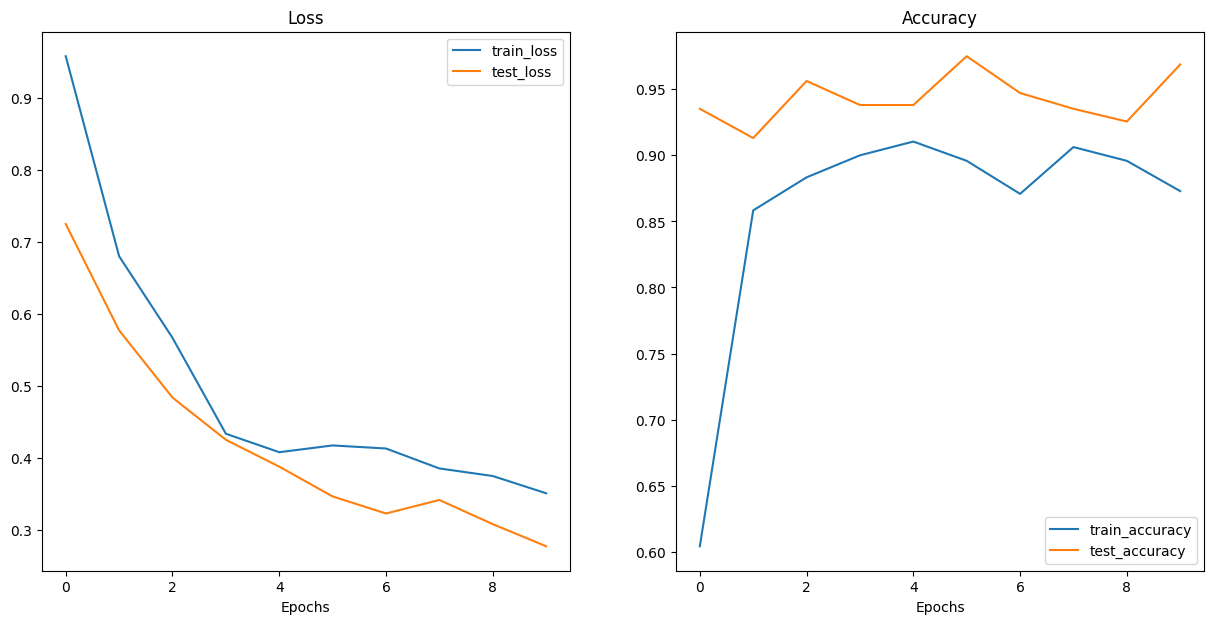

In [88]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetB2_results)

In [89]:
from going_modular.going_modular import utils

utils.save_model(model=effnetB2,
                 target_dir="models",
                 model_name="effnetB2_model.pth")

[INFO] Saving model to: models/effnetB2_model.pth


In [90]:
from pathlib import Path

model_path = Path("models/effnetB2_model.pth")
loaded_effnetB2_size = model_path.stat().st_size / (1024 * 1024)
loaded_effnetB2_size # MB 단위

29.8286075592041

In [91]:
effnetB2_total_params = sum(p.numel() for p in effnetB2.parameters())
effnetB2_total_params

7705221

In [92]:
effnetB2_stats = {"test_loss": effnetB2_results['test_loss'][-1],
                  "test_acc": effnetB2_results['test_acc'][-1],
                  "model_size (MB)": loaded_effnetB2_size,
                  "model_params": effnetB2_total_params}

In [93]:
effnetB2_stats

{'test_loss': 0.27697635591030123,
 'test_acc': 0.96875,
 'model_size (MB)': 29.8286075592041,
 'model_params': 7705221}

In [94]:
import torchvision

vitb16model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

In [95]:
def create_vitb16_model(num_classes:int=3):
    vitb16transforms = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()
    vitb16model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
    for param in vitb16model.parameters():
        param.requires_grad = False
    vitb16model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes, bias=True)
    )
    return vitb16model, vitb16transforms

In [96]:
vitb16model, vitb16transforms = create_vitb16_model()

In [97]:
from torchinfo import summary

summary(vitb16model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [98]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names_vit = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vitb16transforms,
    batch_size=32
)

In [99]:
len(train_dataloader_vit), len(test_dataloader_vit), class_names_vit

(15, 5, ['pizza', 'steak', 'sushi'])

In [100]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vitb16model.parameters(), lr=0.001)

set_seeds(42)
vitb16model_results = engine.train(model=vitb16model,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5992 | train_acc: 0.8292 | test_loss: 0.2066 | test_acc: 0.9750
Epoch: 2 | train_loss: 0.2354 | train_acc: 0.9250 | test_loss: 0.1282 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1634 | train_acc: 0.9625 | test_loss: 0.0999 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1165 | train_acc: 0.9646 | test_loss: 0.0863 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1055 | train_acc: 0.9688 | test_loss: 0.0766 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.1170 | train_acc: 0.9458 | test_loss: 0.0699 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0829 | train_acc: 0.9792 | test_loss: 0.0750 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.0856 | train_acc: 0.9875 | test_loss: 0.0648 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0865 | train_acc: 0.9854 | test_loss: 0.0610 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0605 | train_acc: 0.9854 | test_loss: 0.0578 | test_acc: 0.9875


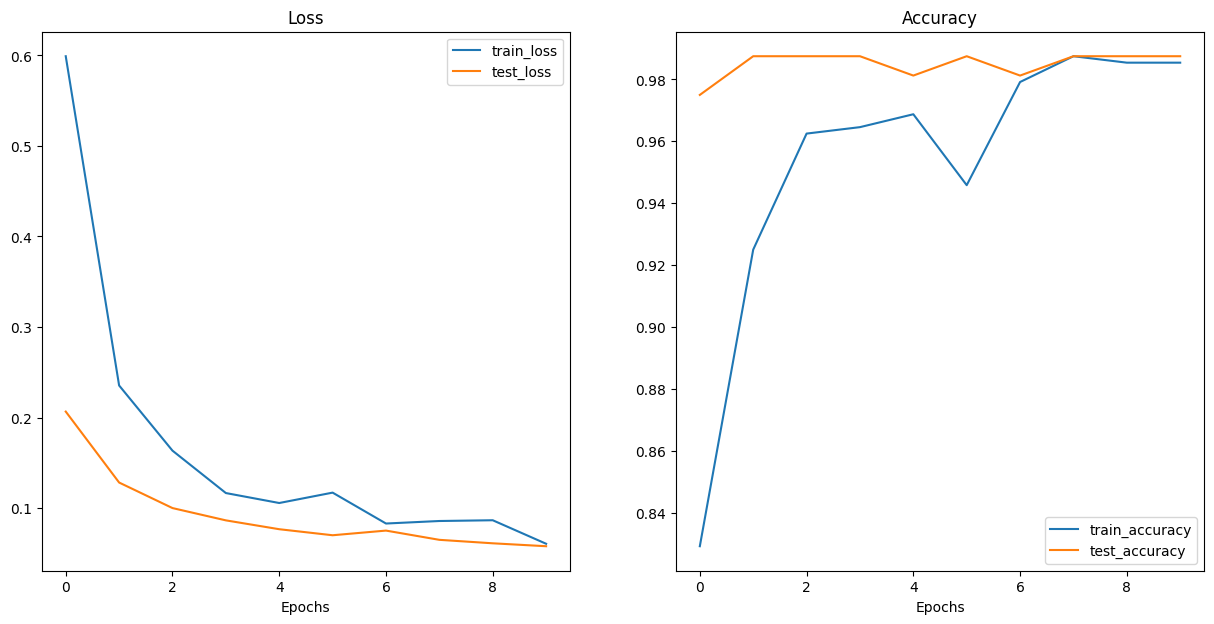

In [101]:
plot_loss_curves(vitb16model_results)

In [102]:
utils.save_model(model=vitb16model,
                 target_dir="models",
                 model_name="vitb16_model.pth")

[INFO] Saving model to: models/vitb16_model.pth


In [103]:
vitb16model_path = Path("models/vitb16_model.pth")
loaded_vitb16model_size = vitb16model_path.stat().st_size / (1024 * 1024)
loaded_vitb16model_size # MB 단위

327.3629894256592

In [104]:
vitb16model_total_params = sum(p.numel() for p in vitb16model.parameters())
vitb16model_total_params

85800963

In [105]:
vitb16_stats = {"test_loss": vitb16model_results['test_loss'][-1],
                  "test_acc": vitb16model_results['test_acc'][-1],
                  "model_size (MB)": loaded_vitb16model_size,
                  "model_params": vitb16model_total_params}
vitb16_stats

{'test_loss': 0.05777871697209776,
 'test_acc': 0.9875,
 'model_size (MB)': 327.3629894256592,
 'model_params': 85800963}

In [106]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/416067.jpg')]

In [107]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}

        pred_dict['inage_path'] = path
        class_name = path.parent.stem
        pred_dict['actual_class'] = class_name

        start_time = timer()
        img = Image.open(path)
        img = transform(img).unsqueeze(dim=0).to(device)
        model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logits = model(img)
            pred_prob = torch.softmax(pred_logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_dict['predicted_class'] = class_names[pred_label.cpu()]
            pred_dict['pred_prob'] = pred_prob.unsqueeze(0).max().cpu().item()
            end_time = timer()
            pred_dict['inference_time'] = round(end_time - start_time, 3)

        pred_dict['correct'] = pred_dict['actual_class'] == pred_dict['predicted_class']
        pred_list.append(pred_dict)
    return pred_list

In [108]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetB2,
                                          transform=effnetB2_transforms,
                                          class_names=class_names,
                                          device=device)

  0%|          | 0/150 [00:00<?, ?it/s]

In [109]:
effnetb2_test_pred_dicts

[{'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.9276300668716431,
  'inference_time': 0.034,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.9657992720603943,
  'inference_time': 0.031,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.7938627004623413,
  'inference_time': 0.028,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.8345844149589539,
  'inference_time': 0.029,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/416067.jpg'),
  'actual_c

In [110]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,inage_path,actual_class,predicted_class,pred_prob,inference_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.927630,0.034,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.965799,0.031,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,pizza,0.793863,0.028,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.834584,0.029,True
4,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.970335,0.028,True


In [111]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,145
False,5


In [112]:
effnetb2_average_time_per_pred = effnetb2_test_pred_df.inference_time.mean()
effnetb2_average_time_per_pred

0.026759999999999996

In [113]:
vitb16_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vitb16model,
                                          transform=vitb16transforms,
                                          class_names=class_names,
                                          device=device)

  0%|          | 0/150 [00:00<?, ?it/s]

In [114]:
vitb16_test_pred_df = pd.DataFrame(vitb16_test_pred_dicts)
vitb16_test_pred_df.head()

,inage_path,actual_class,predicted_class,pred_prob,inference_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.999140,0.032,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.998067,0.029,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,pizza,0.998051,0.029,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.998489,0.031,True
4,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.993425,0.029,True


In [115]:
vitb16_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [116]:
vitb16_average_time_per_pred = vitb16_test_pred_df.inference_time.mean()
vitb16_average_time_per_pred

0.019559999999999994

In [117]:
vitb16_stats['time_per_pred'] = vitb16_average_time_per_pred
effnetB2_stats['time_per_pred'] = effnetb2_average_time_per_pred

In [118]:
df = pd.DataFrame([effnetB2_stats, vitb16_stats])
df['model'] = ['effnetB2', 'vitb16']
df['test_acc'] = df['test_acc'] * 100
df

,test_loss,test_acc,model_size (MB),model_params,time_per_pred,model
0,0.276976,96.875,29.828608,7705221,0.02676,effnetB2
1,0.057779,98.750,327.362989,85800963,0.01956,vitb16


In [119]:
pd.DataFrame(data=df.set_index('model').loc['vitb16'] / df.set_index('model').loc['effnetB2'],
             columns=['vitb16 to effnetB2 ratios']).T


,test_loss,test_acc,model_size (MB),model_params,time_per_pred
vitb16 to effnetB2 ratios,0.208605,1.019355,10.9748,11.135432,0.730942


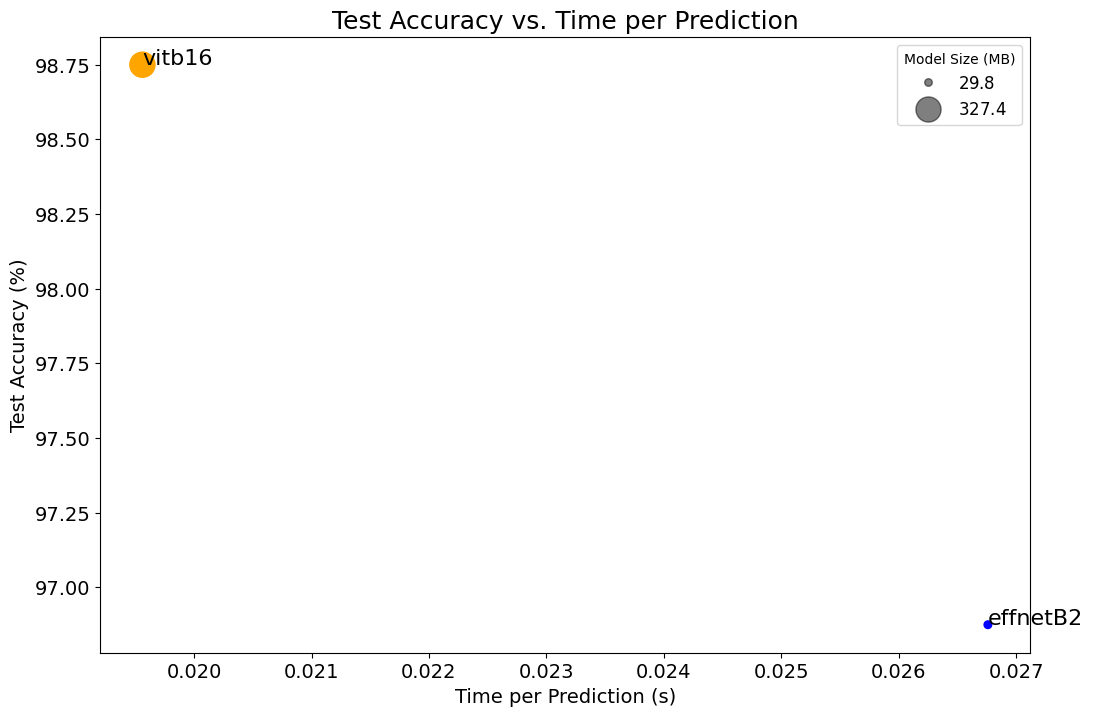

In [120]:
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df, x = 'time_per_pred', y='test_acc', c=['blue', 'orange'], s='model_size (MB)')
ax.set_xlabel('Time per Prediction (s)', fontsize=14)
ax.set_ylabel('Test Accuracy (%)', fontsize=14)
ax.set_title('Test Accuracy vs. Time per Prediction', fontsize=18)
ax.tick_params(axis='both', labelsize=14)

for index, text in enumerate(df['model']):
    ax.annotate(text, (df['time_per_pred'][index], df['test_acc'][index]), fontsize=16)

handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles, labels, loc='upper right', title='Model Size (MB)', fontsize=12)

In [121]:
!pip install gradio

In [122]:
import gradio as gr

effnetB2.to('cpu')

next(iter(effnetB2.parameters())).device

device(type='cpu')

In [123]:
from typing import Tuple, Dict

def predict_img(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetB2_transforms(img).unsqueeze(0)
    model = effnetB2
    model.eval()
    with torch.inference_mode():
        pred_logits = model(img)
        pred_prob = torch.softmax(pred_logits, dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

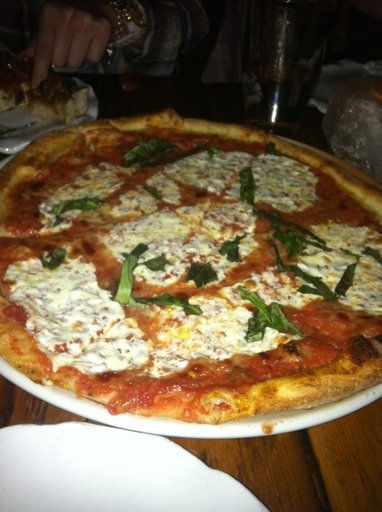

In [124]:
import random
from PIL import Image

img_path = random.choice(test_data_paths)
img = Image.open(img_path)
img

In [125]:
pred_labels_and_probs, pred_time = predict_img(img)
pred_labels_and_probs, pred_time

({'pizza': 0.8736730813980103,
  'steak': 0.1066097691655159,
  'sushi': 0.019717179238796234},
 0.06427)

In [126]:
import gradio as gr

example_list = [str(filepath) for filepath in random.sample(test_data_paths, k=3)]
example_list

['data/pizza_steak_sushi_20_percent/test/steak/864661.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg']

In [127]:
gr.Interface(fn=predict_img,
             inputs=gr.Image(type='pil'),
             outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                      gr.Number(label='Prediction Time (s)')],
             examples=example_list).launch(debug=False)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://08914d23a1e18a0707.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [128]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path('foodvision_mini_demo/')

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)

    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

In [129]:
import shutil
from pathlib import Path

foodvision_mini_example_path = foodvision_mini_demo_path / "examples"

if foodvision_mini_example_path.exists():
    shutil.rmtree(foodvision_mini_example_path)

    foodvision_mini_example_path.mkdir(parents=True, exist_ok=True)
else:
    foodvision_mini_example_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_example_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to foodvision_mini_demo/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to foodvision_mini_demo/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to foodvision_mini_demo/examples/2582289.jpg


In [130]:
import os

example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_example_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

In [131]:
import shutil

effnetB2_model_path = '/content/models/effnetB2_model.pth'

effnetB2_model_destination = foodvision_mini_demo_path / effnetB2_model_path.split('/')[-1]

try:
    print(f"[INFO] Copying {effnetB2_model_path} to {effnetB2_model_destination}")
    shutil.copy2(src=effnetB2_model_path, dst=effnetB2_model_destination)
    print(f"[INFO] {effnetB2_model_path} copied to {effnetB2_model_destination}")
except:
    print(f"[ERROR] Couldn't copy {effnetB2_model_path} to {effnetB2_model_destination}")
    print(f"[INFO] You may already have a model copy at {effnetB2_model_destination}")

[INFO] Copying /content/models/effnetB2_model.pth to foodvision_mini_demo/effnetB2_model.pth
[INFO] /content/models/effnetB2_model.pth copied to foodvision_mini_demo/effnetB2_model.pth


In [132]:
%%writefile foodvision_mini_demo/model.py

import torch
from torchvision import transforms
from torchvision.models import EfficientNet_B2_Weights, efficientnet_b2

from torch import nn

def create_effnetb2_model(num_classes:int=3):
    effnetB2weights = EfficientNet_B2_Weights.DEFAULT
    effnetB2transforms = effnetB2weights.transforms()
    effnetB2 = efficientnet_b2(weights=effnetB2weights)
    for param in effnetB2.features.parameters():
        param.requires_grad = False
    effnetB2.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )
    return effnetB2, effnetB2transforms

Writing foodvision_mini_demo/model.py


In [133]:
from foodvision_mini_demo import model

effnetB2, effnetB2_transforms = model.create_effnetb2_model()

In [134]:
%%writefile foodvision_mini_demo/app.py
import gradio as gr
from typing import Tuple, Dict
from foodvision_mini_demo import model
import torch
import os
from PIL import Image
from timeit import default_timer as timer

class_names = ['pizza', 'steak', 'sushi']

effnetB2, effnetB2_transforms = model.create_effnetb2_model(num_classes=len(class_names))
effnetB2.load_state_dict(torch.load(f='effnetB2_model.pth', map_location=torch.device('cpu')))

def predict_img(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetB2_transforms(img).unsqueeze(0)
    model = effnetB2
    model.eval()
    with torch.inference_mode():
        pred_logits = model(img)
        pred_prob = torch.softmax(pred_logits, dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_example_path)]

gr.Interface(fn=predict_img,
             inputs=gr.Image(type='pil'),
             outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                      gr.Number(label='Prediction Time (s)')],
             examples=example_list).launch(debug=False)

Writing foodvision_mini_demo/app.py


In [135]:
%%writefile foodvision_mini_demo/requirements.txt
torch
torchvision
gradio

Writing foodvision_mini_demo/requirements.txt


In [136]:
!ls foodvision_mini_demo

app.py	effnetB2_model.pth  examples  model.py	requirements.txt


In [137]:
!cd foodvision_mini_demo && zip -r foodvision_mini_demo.zip  * -x "*.pyc" "*.ipynb" "__pycache__" "*ipynb_checkpoints*"

  adding: app.py (deflated 52%)
  adding: effnetB2_model.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 4%)


In [138]:
from google.colab import files

files.download('/content/foodvision_mini_demo/foodvision_mini_demo.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://huggingface.co/spaces/Eunwoo-Choi/foodvision_mini_practice

In [139]:
effnetB2_food101, effnetB2_food101_transforms = create_effnetb2_model(num_classes=101)

In [140]:
summary(effnetB2_food101, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 101]        --              Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              False
│    │    └─MBConv (0)                                   

In [141]:
food101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(), effnetB2_food101_transforms])

In [142]:
food101_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [144]:
from torchvision import datasets

from pathlib import Path
data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                                    split="train",
                                    download=True,
                                    transform=food101_transforms)
test_data = datasets.Food101(root=data_dir,
                                    split="test",
                                    download=True,
                                    transform=effnetB2_food101_transforms)

100%|██████████| 4996278331/4996278331 [04:51<00:00, 17149289.04it/s]


Extracting data/food-101.tar.gz to data


In [145]:
food101_class_names = train_data.classes
food101_class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [146]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2, seed:int=42):
    size1 = int(len(dataset) * split_size)
    size2 = len(dataset) - size1
    dataset1, dataset2 = random_split(dataset=dataset,
                                                lengths=[size1, size2],
                                                generator=torch.Generator().manual_seed(seed))
    return dataset1, dataset2

In [147]:
train_food101_split20, _ = split_dataset(train_data, split_size=0.2)
test_food101_split20, _ = split_dataset(test_data, split_size=0.2)

In [148]:
len(train_food101_split20), len(test_food101_split20)

(15150, 5050)

In [150]:
train_food101_full_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              num_workers=os.cpu_count(),
                                                              pin_memory=True)
test_food101_full_loader = torch.utils.data.DataLoader(dataset=test_data,
                                                              batch_size=32,
                                                              shuffle=False,
                                                              num_workers=os.cpu_count(),
                                                              pin_memory=True)

In [149]:
train_food101_split20_loader = torch.utils.data.DataLoader(dataset=train_food101_split20,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              num_workers=os.cpu_count(),
                                                              pin_memory=True)
test_food101_split20_loader = torch.utils.data.DataLoader(dataset=test_food101_split20,
                                                              batch_size=32,
                                                              shuffle=False,
                                                              num_workers=os.cpu_count(),
                                                              pin_memory=True)

In [151]:
len(train_food101_full_loader), len(test_food101_full_loader), len(train_food101_split20_loader), len(test_food101_split20_loader)

(2368, 790, 474, 158)

In [152]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetB2_food101.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds(42)
effnetB2_food101_results = engine.train(model=effnetB2_food101,
                                train_dataloader=train_food101_full_loader,
                                test_dataloader=test_food101_full_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9335 | train_acc: 0.4182 | test_loss: 2.1578 | test_acc: 0.6144
Epoch: 2 | train_loss: 2.5898 | train_acc: 0.4975 | test_loss: 2.0987 | test_acc: 0.6304
Epoch: 3 | train_loss: 2.5450 | train_acc: 0.5096 | test_loss: 2.0527 | test_acc: 0.6447
Epoch: 4 | train_loss: 2.5154 | train_acc: 0.5184 | test_loss: 2.0373 | test_acc: 0.6502
Epoch: 5 | train_loss: 2.5042 | train_acc: 0.5232 | test_loss: 2.0392 | test_acc: 0.6509
Epoch: 6 | train_loss: 2.5033 | train_acc: 0.5220 | test_loss: 2.0132 | test_acc: 0.6585
Epoch: 7 | train_loss: 2.5040 | train_acc: 0.5202 | test_loss: 2.0280 | test_acc: 0.6529
Epoch: 8 | train_loss: 2.4951 | train_acc: 0.5246 | test_loss: 2.0401 | test_acc: 0.6477
Epoch: 9 | train_loss: 2.4991 | train_acc: 0.5219 | test_loss: 2.0349 | test_acc: 0.6507
Epoch: 10 | train_loss: 2.4924 | train_acc: 0.5264 | test_loss: 2.0179 | test_acc: 0.6568


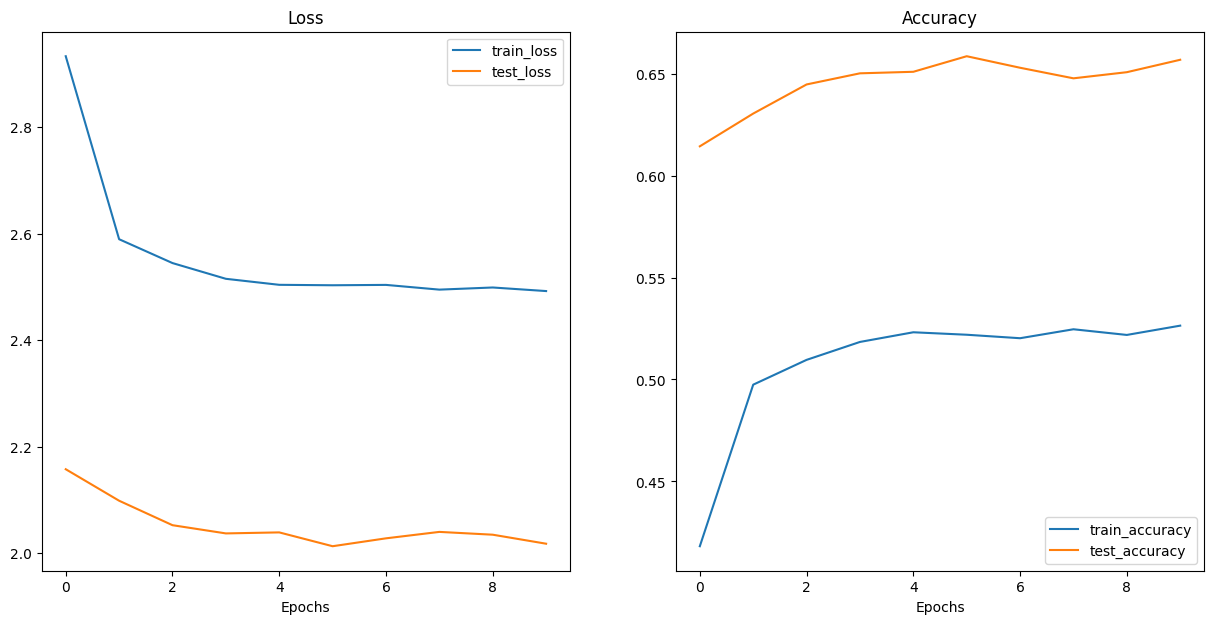

In [153]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetB2_food101_results)

In [154]:
from going_modular.going_modular import utils

effnetB2_food101_path = Path("models/effnetB2_food101_model.pth")

utils.save_model(model=effnetB2_food101,
                 target_dir="models",
                 model_name="effnetB2_food101_model.pth")

[INFO] Saving model to: models/effnetB2_food101_model.pth


In [156]:
loaded_effnetB2_food101, loaded_effnetB2_food101_transforms = create_effnetb2_model(num_classes=101)
loaded_effnetB2_food101.load_state_dict(torch.load(f='/content/models/effnetB2_food101_model.pth'))

<ipython-input-156-73c84414f694>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetB2_food101.load_state_dict(torch.load(f='/content/models/effnetB2_food101_mode

<All keys matched successfully>

In [157]:
from pathlib import Path

food101_demo_path = Path("food101_demo")

food101_demo_path.mkdir(parents=True, exist_ok=True)

(food101_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [160]:
!ls food101_demo/

examples


In [161]:
from pathlib import Path

model_path = Path("models/effnetB2_food101_model.pth")
loaded_effnetB2_101_size = model_path.stat().st_size / (1024 * 1024)
loaded_effnetB2_101_size # MB 단위

30.3594913482666

In [163]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg food101_demo/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/effnetB2_food101_model.pth food101_demo/

--2024-10-01 04:01:12--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg.1’

04-pizza-dad.jpeg.1 100%[===================>]   2.74M  11.9MB/s    in 0.2s    

2024-10-01 04:01:12 (11.9 MB/s) - ‘04-pizza-dad.jpeg.1’ saved [2874848/2874848]

mv: cannot stat 'models/effnetB2_food101_model.pth': No such file or directory


In [165]:
food101_class_names_path = food101_demo_path / "class_names.txt"

with open(food101_class_names_path, "w") as f:
    f.write("\n".join(food101_class_names))

In [166]:
with open(food101_class_names_path, "r") as f:
    food101_class_names_loaded = [class_name.strip() for class_name in f.readlines()]

food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [167]:
%%writefile food101_demo/model.py

import torch
from torchvision import transforms
from torchvision.models import EfficientNet_B2_Weights, efficientnet_b2

from torch import nn

def create_effnetb2_model(num_classes:int=101):
    effnetB2weights = EfficientNet_B2_Weights.DEFAULT
    effnetB2transforms = effnetB2weights.transforms()
    effnetB2 = efficientnet_b2(weights=effnetB2weights)
    for param in effnetB2.features.parameters():
        param.requires_grad = False
    effnetB2.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )
    return effnetB2, effnetB2transforms

Writing food101_demo/model.py


In [168]:
%%writefile food101_demo/app.py
import gradio as gr
from typing import Tuple, Dict
import model
import torch
import os
from PIL import Image
from timeit import default_timer as timer

with open(food101_class_names_path, "r") as f:
    class_names = [class_name.strip() for class_name in f.readlines()]

effnetB2, effnetB2_transforms = model.create_effnetb2_model(num_classes=len(class_names))
effnetB2.load_state_dict(torch.load(f='effnetB2_food_101_model.pth', map_location=torch.device('cpu')))

def predict_img(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetB2_transforms(img).unsqueeze(0)
    model = effnetB2
    model.eval()
    with torch.inference_mode():
        pred_logits = model(img)
        pred_prob = torch.softmax(pred_logits, dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

example_list = [['examples/' + example] for example in os.listdir('food101_demo/')]

gr.Interface(fn=predict_img,
             inputs=gr.Image(type='pil'),
             outputs=[gr.Label(num_top_classes=10, label='Predictions'),
                      gr.Number(label='Prediction Time (s)')],
             examples=example_list).launch(debug=False)

Writing food101_demo/app.py


In [169]:
%%writefile food101_demo/requirements.txt
torch
torchvision
gradio

Writing food101_demo/requirements.txt


In [170]:
# Zip foodvision_big folder but exclude certain files
!cd food101_demo && zip -r ../food101_demo.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 52%)
  adding: class_names.txt (deflated 48%)
  adding: effnetB2_food101_model.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 4%)


In [171]:
# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("food101_demo.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>